Goal: Create a daily NAO index using the CPC methodology 
=====

Author: [Ray Bell](https://github.com/raybellwaves)

Use the time period of the [SubX](http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/) hindcast: 1999-2016.
For a saninty check make sure that 1999-2016 is indeed the hindcast period:

In [1]:
import numpy as np
import xarray as xr


remote_data = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models'\
                              '/.SubX/.RSMAS/.CCSM4/.hindcast/.zg/dods')
print(remote_data.coords['S'])

<xarray.DataArray 'S' (S: 6569)>
array(['1999-01-07T00:00:00.000000000', '1999-01-08T00:00:00.000000000',
       '1999-01-09T00:00:00.000000000', ..., '2016-12-29T00:00:00.000000000',
       '2016-12-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * S        (S) datetime64[ns] 1999-01-07 1999-01-08 1999-01-09 1999-01-10 ...
Attributes:
    pointwidth:     0.0
    long_name:      Start Time
    standard_name:  forecast_reference_time
    gridtype:       0


The data used here is geopotential height at 500 hPa ($Z_{500}$) from ERA-Interim. This data was simply copied from the University of Reading archive. You can however use the [API](https://software.ecmwf.int/wiki/display/CKB/How+to+download+data+via+the+ECMWF+WebAPI) to download the data from ECMWF.

Two files exists in this directory `ERAI_z500_monthly_1999-2016.nc` (43 Mb) and `b.nc`. `ERAI_z500_monthly_1999-2016.nc` is the monthly mean of $Z_{500}$ January 1996 - December 2016. `b.nc` is daily $Z_{500}$ January 1st 1996 - December 31st 2016. The data has been interpolated to 1° to match the SubX data (360x181) and cut to 20°N-90°N for the analysis. The reference scripts for the data processing beforehand are in the directory `pre_proc`. DO THIS!

CPC's methodology for the daily NAO index can be found [here](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/history/method.shtml), with some more information [here](http://www.cpc.ncep.noaa.gov/data/teledoc/telepatcalc.shtml). The procedure is based on [Barston and Livezey (1987)](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493%281987%29115%3C1083%3ACSAPOL%3E2.0.CO%3B2).

My understanding of the methodology is as follows:

1. Use the region of 20°N-90°N with standardized $Z_{500}$ anomalies.

2. Calculate the 10 leading EOFs for each calendar month centred on that month with a window of 3 months. e.g. February is based on January-February-March (JFM). Decisions have to be made for January and December: whether to just use the two-month window or leave out the season. (It shouldn't really matter).

3. Rotate the EOFs using the varimax methodology.

4. Linearly interpolate the monthly spatial pattern to the day in question. e.g. February 1$^{st}$ will be linearly interpolated from the DJF pattern (think of the pattern defined mid-way through the mid-month: e.g. January 15$^{th}$) and the JFM pattern (February 15$^{th}$).

5. Least squared regression approach for daily data? (e.g. last paragraph in the NAO/PNA section [here](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/history/method.shtml) (I don't understand this)

Try creating a daily index for one day e.g. February 15$^{th}$ 2009

First we need to obtain the NAO pattern from the monthly data.

Calcualte the 10 leading EOFs for all JFMs

Use xarray's [rolling mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) to do the seasonal averages. Then slice it to get all the JFM's.

In [2]:
da = xr.open_dataarray('ERAI_z500_monthly_1999-2016.nc')
print(da)

sm = da.rolling(time=3).mean().dropna('time')
# Make note that time is now given as the last month in the window e.g. JFM has time 03-16T09 (MM-DDTHH)
print('')
print(sm)

# Use numpy's slice index to get all the JFM's
jfm = sm[0::12,:,:]
# Check that all the JFM 1999-2016 were correctly sliced 
print('')
print(jfm.coords['time'])

<xarray.DataArray 'gph500hPa' (time: 216, lat: 71, lon: 360)>
[5520960 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
  * time     (time) datetime64[ns] 1999-01-16T09:00:00 1999-02-14T21:00:00 ...
  * lat      (lat) float64 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 ...
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    units:          meters
    name:           Z
    source:         GRIB data
    time:           00:00
    title:          Geopotential

<xarray.DataArray (time: 214, lat: 71, lon: 360)>
array([[[5809.654566, 5810.972497, ..., 5807.253832, 5808.479121],
        [5796.711947, 5797.982469, ..., 5794.312084, 5795.529759],
        ...,
        [5118.6511  , 5118.760763, ..., 5118.42919 , 5118.540497],
        [5117.234469, 5117.234469, ..., 5117.234469, 5117.234469]],

       [[5827.259486, 5829.044683, ..., 5823.829739, 5825.577047],
        [5816.223

Calculate standardized anomalies

In [3]:
jfm_sa = (jfm - jfm.mean(dim=('time'))) / (jfm - jfm.mean(dim=('time'))).std(dim=('time'))
print(jfm_sa)

<xarray.DataArray (time: 18, lat: 71, lon: 360)>
array([[[-1.434221, -1.399658, ..., -1.488877, -1.463079],
        [-1.575146, -1.546949, ..., -1.617144, -1.596318],
        ...,
        [ 0.388063,  0.389183, ...,  0.385737,  0.386912],
        [ 0.333918,  0.333918, ...,  0.333918,  0.333918]],

       [[-0.976046, -1.029718, ..., -0.887624, -0.927455],
        [-0.895222, -0.951696, ..., -0.808763, -0.848008],
        ...,
        [-0.084258, -0.08346 , ..., -0.085797, -0.08504 ],
        [-0.05341 , -0.05341 , ..., -0.05341 , -0.05341 ]],

       ...,

       [[-0.174698, -0.182278, ..., -0.169951, -0.169541],
        [-0.222018, -0.233198, ..., -0.216672, -0.215745],
        ...,
        [-1.31553 , -1.316041, ..., -1.314459, -1.315002],
        [-1.290563, -1.290563, ..., -1.290563, -1.290563]],

       [[ 1.738677,  1.775604, ...,  1.66202 ,  1.702176],
        [ 1.598069,  1.633223, ...,  1.537579,  1.567922],
        ...,
        [ 1.464007,  1.461969, ...,  1.46816 ,  1.4660

Before doing the EOF apply a weighting as cosine of the latitude

In [4]:
data = jfm_sa.values
wgts = np.sqrt(np.cos(np.deg2rad(jfm_sa.coords['lat'].values)).clip(0., 1.))[..., np.newaxis]
weights = np.broadcast_arrays(data[0:1], wgts)[1][0]
data = data * weights
print(np.shape(data))

(18, 71, 360)


Calculate the 10 leading EOF modes. For a basic understanding of EOFs I recommending reading Hannachi's EOF primer [here](http://www.met.rdg.ac.uk/~han/Monitor/eofprimer.pdf) and his paper [here](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/joc.1499). This code is also adapted from Dawson's [eof package](https://github.com/ajdawson/eofs)

In [5]:
# Reshape the data to be (time, space)
records = len(jfm_sa.coords['time'])
originalshape = data.shape[1:]
channels = np.prod(originalshape)
data_flat = data.reshape([records, channels])
print(np.shape(data_flat))

(18, 25560)


In [6]:
# Compute the singular value decomposition
A, Lh, E = np.linalg.svd(data_flat, full_matrices=False)
print(np.shape(A))
print(np.shape(Lh))
print(np.shape(E))

(18, 18)
(18,)
(18, 25560)


In [7]:
# Construct the eigenvalues and normalize by N-1
L = (Lh * Lh) / (float(records - 1))
print(np.shape(L))

# Remove the scaling on the principal component time-series that is
# implicitily introduced by using SVD instead of eigen-decomposition.
# The PCs may be re-scaled later if required.
P = A * Lh
print(np.shape(P)) 

(18,)
(18, 18)


Return the 10 dominant EOFs

In [8]:
# Calculate the Principal Components
npcs = 10
pcs = P[:, 0:npcs] / np.sqrt(L[0:npcs])
# Put it in a DataArray
pcs_da = xr.DataArray(pcs, coords=[jfm_sa.coords['time'], range(pcs.shape[1])],
                      dims=['time', 'mode'], name='pcs')
print(pcs_da)

# Calculate the eofs
flat_eofs = E[0:npcs, :].copy()
eofs = flat_eofs / np.sqrt(L[0:npcs])[:, np.newaxis]
# Return the original shape
eofs2d = eofs.reshape((npcs,) + originalshape)
# Put it in a DataArray
eofs2d_da = xr.DataArray(eofs2d, coords=[range(pcs.shape[1]), jfm_sa.coords['lat'], jfm_sa.coords['lon']],
                         dims=['mode', 'lat', 'lon'], name='eofs')
print(eofs2d_da)

<xarray.DataArray 'pcs' (time: 18, mode: 10)>
array([[-6.151959e-01,  1.147294e+00, -5.250022e-01, -1.896321e+00,
         2.532846e-02, -2.438858e-01,  1.387640e+00, -9.066526e-01,
         3.875247e-01, -2.874359e-01],
       [ 7.362934e-01,  1.564674e+00, -1.083903e+00,  7.890554e-01,
        -8.957162e-02,  7.983542e-01,  4.716413e-01, -1.707907e+00,
         6.178805e-01, -4.393084e-01],
       [-6.385871e-01,  3.468233e-01, -8.878826e-04,  9.573112e-01,
         1.390250e+00,  4.245997e-01, -6.833864e-01,  6.100967e-02,
         1.708617e+00,  3.088802e-01],
       [ 6.509269e-01, -6.865323e-01, -5.009680e-01, -6.362048e-01,
         1.074133e+00,  1.996454e+00, -1.568155e-01, -6.789900e-01,
        -7.080080e-01, -1.678849e-02],
       [ 8.432200e-01, -8.495480e-01,  9.176243e-01,  1.522311e+00,
        -3.320708e-01,  2.167729e-01,  5.415950e-01,  1.496258e-01,
        -1.461457e+00, -1.923358e+00],
       [-1.341464e-01, -1.966205e-01, -1.087644e-01,  1.018083e+00,
        -5.

Calculate the 1$^{st}$ EOF as covariance

In [9]:
# Divide the input by the weighting
data = data / weights

out_shape = (npcs,) + originalshape
data_flat = data.reshape([records, channels])
pcs_flat = pcs.reshape([records, npcs])

# Divisor
div = np.float64(pcs_flat.shape[0] - float(records - 1))
cov = (np.dot(data_flat.T, pcs_flat).T / div).reshape(out_shape)
# Put into DataArray
cov_da = xr.DataArray(cov, coords=[range(pcs.shape[1]), jfm_sa.coords['lat'], jfm_sa.coords['lon']],
                         dims=['mode', 'lat', 'lon'], name='z500')
print(cov_da)

<xarray.DataArray 'eofs' (mode: 10, lat: 71, lon: 360)>
array([[[-11.109956, -11.281669, ..., -10.677983, -10.903685],
        [-10.722605, -10.942151, ..., -10.24355 , -10.489671],
        ...,
        [-12.043508, -12.042397, ..., -12.045505, -12.044542],
        [-11.955381, -11.955381, ..., -11.955381, -11.955381]],

       [[ -8.699857,  -8.639038, ...,  -8.788645,  -8.750716],
        [ -8.691026,  -8.64199 , ...,  -8.761116,  -8.732147],
        ...,
        [ -1.082233,  -1.065579, ...,  -1.116015,  -1.099056],
        [ -1.326728,  -1.326728, ...,  -1.326728,  -1.326728]],

       ...,

       [[ -1.871614,  -2.197864, ...,  -1.2358  ,  -1.545025],
        [ -1.491332,  -1.817983, ...,  -0.898469,  -1.183149],
        ...,
        [  1.984838,   2.000051, ...,   1.954188,   1.969539],
        [  1.984771,   1.984771, ...,   1.984771,   1.984771]],

       [[ -0.218082,   0.015083, ...,  -0.658107,  -0.445275],
        [ -0.046859,   0.214688, ...,  -0.532648,  -0.304628],
    

Plot it

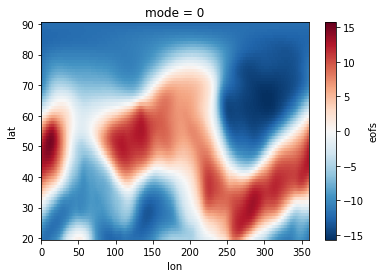

In [11]:
%matplotlib inline
cov_da.isel(mode=0).plot()

Make the plot nicer using [cartopy](https://github.com/SciTools/cartopy)

Enter a start-time an end-time for which to calculate the daily NAO index
e.g. lets look at the large negativate NAO of winter 2008/2009:

In [ ]:
stime = '2009-02-01-T12:00:00'
etime = '2009-02-14-T12:00:00'

Now extend for the winter months (DJF)

In [ ]:
stime = '2008-12-01-T12:00:00'
etime = '2009-02-28-T12:00:00'

Now do for all winters